Group No 02
Group Member Names:
POLISETTI KONDALARAO 2023ab05088 : 100%
PAVAN MARISETTI 2023ab05003 : 100%
AVANEETH KUMAR KAKKAD 2023aa05604 : 100%
SREEDHAR K 2023aa05930 : 100 %

Install  the required packages

In [35]:
!pip install scikit-image
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install opencv-contrib-python 
!pip install joblib
!pip install flask
!pip install kagglehub

## **Import the required libraries


In [36]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.feature import hog, local_binary_pattern
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


## ** Data Acquisition & Preparation

In [37]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dansbecker/urban-and-rural-photos")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\pmarise\.cache\kagglehub\datasets\dansbecker\urban-and-rural-photos\versions\2


In [38]:


rural_path = '/root/.cache/kagglehub/datasets/dansbecker/urban-and-rural-photos/versions/2/train/rural/'
urban_path = '/root/.cache/kagglehub/datasets/dansbecker/urban-and-rural-photos/versions/2/train/urban/'
urban_path = 'data/urban'
rural_path = 'data/rural'

# Function to preprocess images
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128))  # Resize to 128x128
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    equalized = cv2.equalizeHist(gray)  # Histogram equalization
    smoothed = cv2.GaussianBlur(equalized, (5, 5), 0)  # Gaussian smoothing
    return smoothed

# Load dataset
def load_dataset(urban_path, rural_path):
    data = []
    labels = []
    for file in os.listdir(urban_path):
        data.append(preprocess_image(os.path.join(urban_path, file)))
        labels.append(0)  # Urban = 0
    for file in os.listdir(rural_path):
        data.append(preprocess_image(os.path.join(rural_path, file)))
        labels.append(1)  # Rural = 1
    return np.array(data), np.array(labels)

# Load and preprocess images
data, labels = load_dataset(urban_path, rural_path)

Remarks
For this assignment download the dataset from https://www.kaggle.com/datasets/dansbecker/urban-and-rural-photos add urban and rural photos directory to present working directory

Image Preprocessing

All images are resized to 128x128 pixels for uniformity, which ensures consistent input dimensions for feature extraction and model training.
Then we've converted images to grayscale.
Then we did Histogram Equalization to improve image contrast, to make key features (for example, edges, textures) more prominent.
After that, Gaussian Smoothing is used to reduce noise in the images, which will help to avoid false feature detections.

Total number of images: 72
Number of Urban images: 36
Number of Rural images: 36


C:\Users\pmarise\AppData\Local\Temp\ipykernel_17188\258150787.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_labels, y=category_counts, palette="viridis")


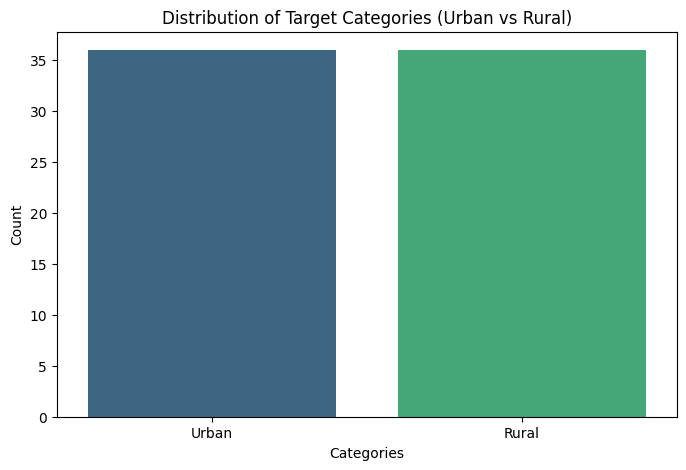

In [39]:
# Check the total size of the dataset and number of images per category
total_images = len(data)
urban_count = sum(1 for label in labels if label == 0)  # Assuming 0 = Urban
rural_count = sum(1 for label in labels if label == 1)  # Assuming 1 = Rural

print(f"Total number of images: {total_images}")
print(f"Number of Urban images: {urban_count}")
print(f"Number of Rural images: {rural_count}")

import seaborn as sns
import matplotlib.pyplot as plt
# Plot the distribution of categories
category_counts = [urban_count, rural_count]
category_labels = ["Urban", "Rural"]

plt.figure(figsize=(8, 5))
sns.barplot(x=category_labels, y=category_counts, palette="viridis")
plt.title("Distribution of Target Categories (Urban vs Rural)")
plt.xlabel("Categories")
plt.ylabel("Count")
plt.show()

## **Split the data into training set and testing set **


In [40]:
# Split data before feature extraction
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (57, 128, 128)
Testing set size: (15, 128, 128)


## ** Feature Engineering
Extract the features from the images and concatenate them to create a single for the every images.

You can choose from the feature processing techniques taught in the class : Low-level Vision: Histogram and Histogram equalization, Gray-scale transformation, Image Smoothing, Connected components in images.

Mid-level Vision: Edge Detection using Gradients, Sobel, Canny; Line detection using Hough transforms; Semantic information using RANSAC;Image region descriptor using SIFT; Use case: Pedestrian detection Using HoG and SIFT descriptors and SVM

Create multiple sets of features and store it in seperate dataframes so that you can later use it for training and comparing the models.

Normalize the DataFrame

Note : If the feature size is getting too large such that it is not fitting into the RAM of Colab or your system then you can either use PCA or resize the image to smaller dimenssion for reducing the numer of features

In [41]:
# HOG Features
def extract_hog_features(image):
    features, _ = hog(image, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True )
    return features

# LBP Features
def extract_lbp_features(image):
    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    return np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)[0]

# Edge Detection Features
def extract_edge_features(image):
    edges = cv2.Canny(image, threshold1=100, threshold2=200)
    return edges

# Extract features for a dataset
#
def extract_features(data,feature_type):
    features = []

    for image in data:
        #print(image)
        hog_features = extract_hog_features(image)
        lbp_features = extract_lbp_features(image)
        edge_features = extract_edge_features(image)
        hog_features_edge = extract_hog_features(edge_features)
        lbp_features_edge = extract_lbp_features(edge_features)
        edge_hog_lbp = extract_lbp_features(edge_features)
        if feature_type == 'hog':
            features.append(np.hstack([hog_features]))
        elif feature_type == 'lbp':
            features.append(np.hstack([lbp_features]))
        elif feature_type == 'edge':
            features.append(np.hstack([edge_features.flatten()]))
        elif feature_type == 'lbp_edge':
            features.append(np.hstack([lbp_features_edge]))
        elif feature_type == 'hog_edge':
            features.append(np.hstack([hog_features_edge]))
        elif feature_type == 'hog_lbp_with_edge':
            features.append(np.hstack([hog_features_edge,lbp_features_edge]))

    return np.array(features)

#To run any combination please change the filter variable below
# 1.hog , 2.lbp , 3.edge , 4.hog_with_edge 5.lbp_with_edge 6.hog_lbp_with_edge
Filter='hog_lbp_with_edge'


X_train_features = extract_features(X_train,Filter)
print(X_train_features.shape)
X_test_features = extract_features(X_test,Filter)



# Normalize features
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)


(57, 8110)


 ### **Model Building **

In [42]:
init_model = RandomForestClassifier(random_state=42)


## ** Initialising the  parameter grid **

In [43]:
param_grid = {
    'n_estimators': [200, 400],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}


## ** Search for the best parameters using the GridSearchCV **

In [44]:
CV_rfc = GridSearchCV(estimator=init_model, param_grid=param_grid, cv= 5)


In [45]:
CV_rfc.fit(X_train_features, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 400]})

** get the best parameters **

In [46]:
best_params = CV_rfc.best_params_
print(best_params)
best_crit = best_params['criterion']
best_depth = best_params['max_depth']
best_mxfetures = best_params['max_features']
best_ests = best_params['n_estimators']
print(best_crit,best_depth,best_mxfetures,best_ests)


{'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 200}
gini 7 log2 200


# create a new model with best parameters found using grid search


In [47]:
rf_model =RandomForestClassifier(random_state=42, max_features=best_mxfetures, n_estimators=best_ests , max_depth=best_depth, criterion=best_crit)


In [48]:
rf_model.fit(X_train_features, y_train)

RandomForestClassifier(max_depth=7, max_features='log2', n_estimators=200,
                       random_state=42)

** Do the predictions

In [49]:
# Evaluate Random Forest
rf_predictions = rf_model.predict(X_test_features)
print(rf_predictions)

[0 1 0 0 0 0 0 1 0 1 1 0 1 1 0]


## **Model Inference & Evaluation**
** Validation matrix **

Random Forest Classification Report: hog_lbp_with_edge


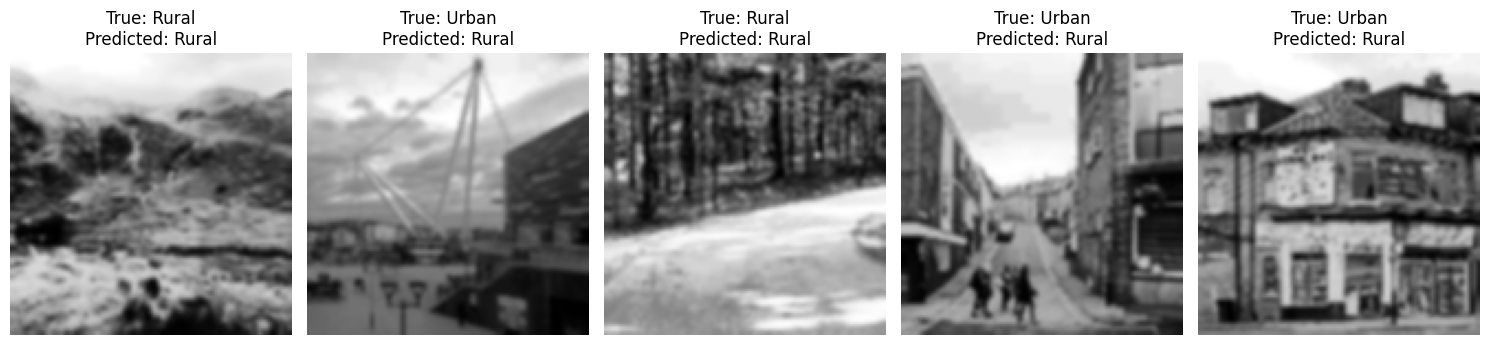

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.67      0.80      0.73         5

    accuracy                           0.80        15
   macro avg       0.78      0.80      0.78        15
weighted avg       0.81      0.80      0.80        15



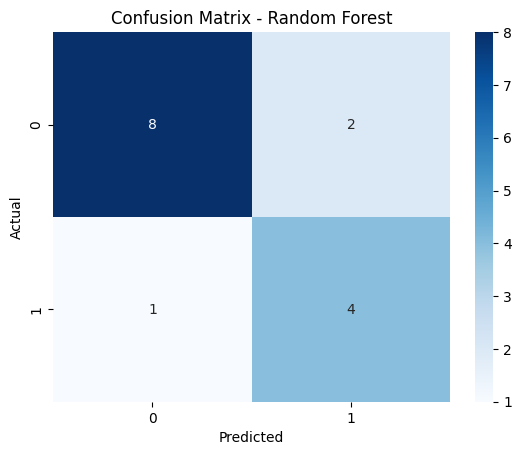

In [50]:
import random
import matplotlib.pyplot as plt

# Function to plot test images with predictions and actual labels
def plot_random_predictions(X_test, y_test, model, n=5):
    # Get random indices for test images
    random_indices = random.sample(range(len(X_test)), n)
    images = X_test[random_indices]
    true_labels = y_test[random_indices]

    # Extract features for the selected test images
    features = extract_features(images,Filter)

    # Get predictions from the model
    predictions = model.predict(features)

    # Map numerical labels to category names
    label_map = {0: "Urban", 1: "Rural"}
    true_labels_names = [label_map[label] for label in true_labels]
    predicted_labels_names = [label_map[label] for label in predictions]

    # Plot the images with predictions and true labels
    plt.figure(figsize=(15, 10))
    for i, image in enumerate(images):
        plt.subplot(1, n, i + 1)
        plt.imshow(image, cmap="gray")
        plt.axis("off")
        plt.title(f"True: {true_labels_names[i]}\nPredicted: {predicted_labels_names[i]}")
    plt.tight_layout()
    plt.show()

# Plot 5 random test images
print("Random Forest Classification Report:",Filter)
plot_random_predictions(X_test, y_test, rf_model, n=5)
print(classification_report(y_test, rf_predictions))

conf_matrix = confusion_matrix(y_test, rf_predictions)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## ** Save the model, serialisation

In [51]:
# Save the model to a pickle file
import pickle

with open('mlopsM3_cvimg_classifier.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("Model saved to mlopsM3_cvimg_classifier.pkl")

Model saved to mlopsM3_cvimg_classifier.pkl


## ** predict using the above serialized .pkl file 

In [52]:
# To load the model back

with open('mlopsM3_cvimg_classifier.pkl', 'rb') as f:

    loaded_model = pickle.load(f)

print("Model loaded from mlopsM3_cvimg_classifier.pkl")

rf_predictions = loaded_model.predict(X_test_features)
print(rf_predictions)

Model loaded from mlopsM3_cvimg_classifier.pkl
[0 1 0 0 0 0 0 1 0 1 1 0 1 1 0]
